In [343]:
import ee
import geemap
import os
import numpy as np
from matplotlib import pyplot as plt

In [344]:
#Create Map and center on Manauas EC Flux Tower coordinates
Map = geemap.Map(center = (-2.609097222, -60.20929722), zoom = 10)
brma2_point = ee.Geometry.Point(-60.20929722, -2.609097222)
brma2_region = ee.Geometry.Rectangle(-60.50, -2.85, -60.00, -2.35)
Map

Map(center=[-2.609097222, -60.20929722], controls=(WidgetControl(options=['position'], widget=HBox(children=(T…

In [345]:
Map.addLayer(brma2_region, {}, 'Manauas Region')

In [346]:
#Calculate NDRE and set palette
def addNDRE(image):
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return image.addBands(ndre)
ndre_params = ({'min': 0.0,'max': 1.0, 'palette' : 
               ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']})

In [347]:
#Create cloud mask
cloudBitMask = ee.Number(2).pow(10).int()
cirrusBitMask = ee.Number(2).pow(11).int()
def maskS2clouds(image):
    qa = image.select('QA60')
    # Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0)))
    return image.updateMask(mask)

In [348]:
#Load sentinel-2 data and clip to brma_2; set visual params
s2 = (ee.ImageCollection('COPERNICUS/S2') #Select S2 1-C level data
     .filterBounds(brma2_region) #Grab tiles that intersect Manaus, BR, region
     .filterDate('2016-01-01', '2016-12-31') #Select year I want
     .map(addNDRE)) #Select bands I want

In [349]:
#Create a masked collection
masked = s2.map(maskS2clouds)

In [350]:
#Find median NDRE of each month in 2016 and save to image collection
months = ee.List.sequence(1, 12) #Create a list with nums 1-12

def byMonth (m):
    month = (masked.filter(ee.Filter.calendarRange(m, m, 'month')) #(start, end, field)
             .median() #Calculate median for all bands I selected
             .set('month', m)) #Make month a property
    return month

masked_collection = ee.ImageCollection.fromImages(months.map(byMonth))
masked_collection = masked_collection.map(lambda image: image.clip(brma2_region))

In [355]:
#Select one image from the collection
july = masked_collection.filterMetadata('month', 'equals', 7) #1 is January, 12 is December
july = july.median() #Set up image for Numpy function below
Map.addLayer(month, {'bands': ['B4', 'B3', 'B2'], 'max': 3000}, 'jul masked')

In [356]:
#Dr. Wu's ee_to_numpy function re-written:
#NOTE: I will need to find a way to iterate over a collection...
bands = july.bandNames().getInfo()
print(str('band names: ') + str(bands))

band_arrs = july.sampleRectangle(region=brma2_point) #2-D pixel array as property per band
band_values = [] #Create empty array
for band in bands:
    band_arr = band_arrs.get(band).getInfo() #Get property values for each band
    band_value = np.array(band_arr) #Create numpy array
    band_values.append(band_value) #Fill empty array
    
values = np.dstack(band_values) #Create variable for filled array
values = values.flatten() #Turn 3D array into 1D array
print(str('band values: ') + str(values)) #Print the filled array

band names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'NDRE']
band values: [1.1530000e+03 8.7550000e+02 7.3250000e+02 4.6100000e+02 7.4350000e+02
 1.9195000e+03 2.5385000e+03 2.3885000e+03 2.9375000e+03 3.2750000e+02
 1.4500000e+01 1.3240000e+03 4.7300000e+02 0.0000000e+00 0.0000000e+00
 0.0000000e+00 5.2534008e-01]


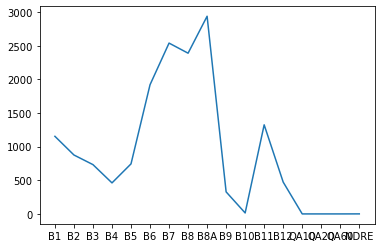

In [357]:
#Create a basic plot
x = bands
y = values
plt.plot(x,y) 
plt.show()

In [339]:
#Make sure you dont have 1 million images to download...
count = masked_collection.size().getInfo()
print(count)

12


In [340]:
#See what properties are included in my collection
properties = masked_collection.first().propertyNames().getInfo()
print(properties)

['month', 'system:footprint', 'system:index', 'system:bands', 'system:band_names']


In [33]:
#Export all 12 images into a file
#This is quite slow, but it does work
out_dir = '/Users/morgansteckler/Desktop/All_Months/'
geemap.ee_export_image_collection(collection, out_dir, region = brma2_region, scale = 20, file_per_band=False)

Total number of images: 12

Exporting 1/12: 0.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/morgansteckler/Desktop/All_Months/0.tif


Exporting 2/12: 1.tif
Generating URL ...


KeyboardInterrupt: 